## Test for shape shift without using sqlite database
### --Shape_shift.py

In [1]:
import cv2
import numpy as np
import pandas as pd
import pickle
import xgboost as xgb
from matplotlib import pyplot as plt
import skimage
import os
import sys
from time import time
sys.path.append(os.environ['REPO_DIR'])
from extractPatches import patch_extractor
from lib.utils import configuration, run
from matplotlib.path import Path
from shapely.geometry import Polygon

In [4]:
def CDF(x):
    x=np.sort(x)
    size=x.shape[0]
    y=np.arange(0,size)/size
    return x,y


def setup_download_from_s3(rel_fp, recursive=True):
    s3_fp = 's3://mousebrainatlas-data/' + rel_fp
    local_fp = os.environ['ROOT_DIR'] + rel_fp

    if os.path.exists(local_fp):
        print('ALREADY DOWNLOADED FILE')
        return

    if recursive:
        run('aws s3 cp --recursive {0} {1}'.format(s3_fp, local_fp))
    else:
        run('aws s3 cp {0} {1}'.format(s3_fp, local_fp))

def setup_upload_from_s3(rel_fp, recursive=True):
    s3_fp = 's3://mousebrainatlas-data/' + rel_fp
    local_fp = os.environ['ROOT_DIR'] + rel_fp

    if recursive:
        run('aws s3 cp --recursive {0} {1}'.format(local_fp, s3_fp))
    else:
        run('aws s3 cp {0} {1}'.format(local_fp, s3_fp))

In [3]:
def features_extractor(patch,state,params,extractor):
    tile=patch
    contours, _ = cv2.findContours(tile.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    if state=='positive':
        if len(contours)==1:
            object_area = cv2.contourArea(contours[0])
        else:
            areas=[]
            for j in range(len(contours)):
                areas.extend([cv2.contourArea(contours[j])])
            object_area = max(areas)
    else:
        if len(contours)==2:
            object_area = cv2.contourArea(contours[0])-cv2.contourArea(contours[1])
        else:
            areas=[]
            for j in range(len(contours)):
                areas.extend([cv2.contourArea(contours[j])])
            areas=np.sort(areas)
            object_area = areas[-1]-areas[-2]

    if params['preprocessing']['polarity']==-1:
        tile = 255-tile
    min_std=params['preprocessing']['min_std']
    _std = np.std(tile.flatten())

    extracted = []
    if _std < min_std:
        extracted.append([0] * 201)
    else:
        Stats = extractor.segment_cells(tile)
        cells = extractor.extract_blobs(Stats,tile)
        cells = pd.DataFrame(cells)
        cells = cells[cells['padded_patch'].notnull()]
        cells = cells.drop(['padded_patch','left','top'],1)
        cells = np.asarray(cells)
        for k in range(len(cells)):
            cells[k][0] = cells[k][0][:10]
        origin = np.concatenate((np.array(list(cells[:,0])),cells[:,1:]),axis=1)
        for k in range(origin.shape[1]):
            x, y = CDF(origin[:,k])
            ten = [x[np.argmin(np.absolute(y-0.1*(j+1)))] for j in range(10)]
            extracted.extend(ten)
        extracted.extend([cells.shape[0]/object_area*224*224/100])
    return extracted

In [5]:
stack = 'MD594'
fp = os.path.join('CSHL_data_processed', stack, stack + '_sorted_filenames.txt')
setup_download_from_s3(fp, recursive=False)
with open(os.environ['ROOT_DIR']+fp, 'r') as f:
    fn_idx_tuples = [line.strip().split() for line in f.readlines()]
    section_to_filename = {int(idx): fn for fn, idx in fn_idx_tuples}


fname = os.path.join('CSHL_data_processed', stack, 'Annotation.npy')
setup_download_from_s3(fname, recursive=False)
annotation = np.load(os.environ['ROOT_DIR']+fname, allow_pickle = True, encoding='latin1')
contours = pd.DataFrame(annotation)
contours = contours.rename(columns={0:"name", 1:"section", 2:"vertices"})
contours_grouped = contours.groupby('section')

#Parameters
param = {}
param['max_depth']= 3   # depth of tree
param['eta'] = 0.2      # shrinkage parameter
param['silent'] = 1     # not silent
param['objective'] = 'binary:logistic' #'multi:softmax'
param['nthread'] = 7 # Number of threads used
param['num_class']=1
num_round = 100

yamlfile=os.environ['REPO_DIR']+'shape_params.yaml'
params=configuration(yamlfile).getParams()

cell_dir = os.environ['ROOT_DIR'] + 'CSHL_patches_features/MD589/'
raw_images_root = 'CSHL_data_processed/'+stack+'/'+stack+'_prep2_lossless_gray/'
features_fn = 'CSHL_region_features/'
if not os.path.exists(os.environ['ROOT_DIR']+features_fn):
    os.mkdir(os.environ['ROOT_DIR']+features_fn)
features_fn = features_fn+stack+'/'
if not os.path.exists(os.environ['ROOT_DIR']+features_fn):
    os.mkdir(os.environ['ROOT_DIR']+features_fn)

savepath = 'CSHL_shift/'
if not os.path.exists(os.environ['ROOT_DIR']+savepath):
    os.mkdir(os.environ['ROOT_DIR']+savepath)
savepath = savepath+stack+'/'
if not os.path.exists(os.environ['ROOT_DIR']+savepath):
    os.mkdir(os.environ['ROOT_DIR']+savepath)

resol = 0.46
step_size = 22


ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE


/Users/kuiqian/Github/shapeology_code/scripts/lib/utils.py:22: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  self.D=yaml.load(open(yamlFile,'r'))


In [5]:
%%time
section = 137
img_fn = raw_images_root + section_to_filename[section] + '_prep2_lossless_gray.tif'
setup_download_from_s3(img_fn, recursive=False)
img = cv2.imread(os.environ['ROOT_DIR']+img_fn, 2)
m, n = img.shape
margin = 200/0.46
extractor = patch_extractor(params)

polygons = [(contour['name'], contour['vertices']) \
            for contour_id, contour in contours_grouped.get_group(section).iterrows()]

paired_structures = ['5N', '6N', '7N', '7n', 'Amb', 'LC', 'LRt', 'Pn', 'Tz', 'VLL', 'RMC', \
                     'SNC', 'SNR', '3N', '4N', 'Sp5I', 'Sp5O', 'Sp5C', 'PBG', '10N', 'VCA', 'VCP', 'DC']
singular_structures = ['AP', '12N', 'RtTg', 'SC', 'IC']

all_structures = paired_structures + singular_structures

ALREADY DOWNLOADED FILE
CPU times: user 751 ms, sys: 650 ms, total: 1.4 s
Wall time: 1.83 s


In [48]:
%%time
t1 =time()
grid_fn = features_fn + str(section) + '.pkl'
grid_features = {}
count = 0
Scores = {}
for contour_id, contour in polygons:
    structure = contour_id
    if structure not in all_structures:
        continue
    polygon = contour.copy()
    Scores[structure] = {}

    if structure == '7n':
        structure = '7nn'

    fp = []
    fp.append(cell_dir + structure + '/MD589_' + structure + '_positive.pkl')
    fp.append(cell_dir + structure + '/MD589_' + structure + '_negative.pkl')
    features = []
    labels = []
    for state in range(2):
        clouds = pickle.load(open(fp[state], 'rb'))
        features.extend(np.array(clouds))
        labels.extend([1 - state] * len(clouds))
    features = np.array(features)
    labels = np.array(labels)
    X_train = features
    y_train = labels
    dtrain = xgb.DMatrix(X_train, label=y_train)
    bst = xgb.train(param, dtrain, num_round, verbose_eval=False)

    if structure == '7nn':
        structure = '7n'

    [left, right, up, down] = [int(max(min(polygon[:, 0]) - margin, 0)),
                               int(min(np.ceil(max(polygon[:, 0]) + margin), n - 1)),
                               int(max(min(polygon[:, 1]) - margin, 0)),
                               int(min(np.ceil(max(polygon[:, 1]) + margin), m - 1))]
    xs, ys = np.meshgrid(np.arange(left, right + 1), np.arange(up, down + 1), indexing='xy')
    locations = np.c_[xs.flat, ys.flat]

    path = Path(polygon)
    indices_inside = np.where(path.contains_points(locations))[0]
    indices_in = locations[indices_inside]
    x_raw = indices_in[:, 0] - left
    y_raw = indices_in[:, 1] - up
    mask = np.zeros((down - up + 1, right - left + 1))
    for i in range(len(indices_in)):
        mask[y_raw[i], x_raw[i]] = 1
    mask = mask.astype(np.uint8)

    Scores[structure][str(section)+'_positive'] = {}
    x_shift = []
    y_shift = []
    for i in range(-10,11):
        try:
            nleft = int(max(left+i*step_size, 0))
            nright = int(min(right+i*step_size, n-1))
            patch = img[up:down + 1, nleft:nright + 1] * mask[:,int(nleft -left-i*step_size):\
                                                         int(nleft -left-i*step_size)+nright - nleft + 1]
            
#             plt.figure()
#             plt.imshow( patch, cmap='gray')
#             plt.title('x'+str(i))

            grid_index = str(section) + '_' + structure + '_' + 'postive_x_'+str(i)
            if grid_index in grid_features.keys():
                extracted = grid_features[grid_index]
            else:
                extracted = features_extractor(patch,'positive',params,extractor)
                grid_features[grid_index] = extracted

            xtest = xgb.DMatrix(extracted)
            score = bst.predict(xtest, output_margin=True, ntree_limit=bst.best_ntree_limit)
            x_shift.extend([score])
        except:
            x_shift.extend([0])

        try:
            nup = int(max(up+i*step_size, 0))
            ndown = int(min(down+i*step_size, n-1))
            patch = img[nup:ndown + 1, left:right + 1] * mask[int(nup -up-i*step_size):\
                                                         int(nup -up-i*step_size)+ndown - nup + 1, :]
#             plt.figure()
#             plt.imshow( patch, cmap='gray')
#             plt.title('y'+str(i))

            grid_index = str(section) + '_' + structure + '_' + 'postive_y_' + str(i)
            if grid_index in grid_features.keys():
                extracted = grid_features[grid_index]
            else:
                extracted = features_extractor(patch, 'positive', params, extractor)
                grid_features[grid_index] = extracted

            xtest = xgb.DMatrix(extracted)
            score = bst.predict(xtest, output_margin=True, ntree_limit=bst.best_ntree_limit)
            y_shift.extend([score])
        except:
            y_shift.extend([0])

    Scores[structure][str(section)+'_positive']['x'] = x_shift
    Scores[structure][str(section)+'_positive']['y'] = y_shift


    surround = Polygon(polygon).buffer(margin, resolution=2)
    path = Path(list(surround.exterior.coords))

    indices_sur = np.where(path.contains_points(locations))[0]
    indices_outside = np.setdiff1d(indices_sur, indices_inside)
    indices_out = locations[indices_outside]
    x_raw = indices_out[:, 0] - left
    y_raw = indices_out[:, 1] - up
    mask = np.zeros((down - up + 1, right - left + 1))
    for i in range(len(indices_out)):
        mask[y_raw[i], x_raw[i]] = 1
    mask = mask.astype(np.uint8)

    Scores[structure][str(section) + '_negative'] = {}
    x_shift = []
    y_shift = []
    for i in range(-10, 11):
        try:
            nleft = int(max(left + i * step_size, 0))
            nright = int(min(right + i * step_size, n - 1))
            patch = img[up:down + 1, nleft:nright + 1] * mask[:, int(nleft - left - i * step_size): \
                                                            int(nleft - left - i * step_size) + nright - nleft + 1]
#             plt.figure()
#             plt.imshow( patch, cmap='gray')
#             plt.title('x'+str(i))
            grid_index = str(section) + '_' + structure + '_' + 'negative_x_' + str(i)
            if grid_index in grid_features.keys():
                extracted = grid_features[grid_index]
            else:
                extracted = features_extractor(patch, 'negative', params, extractor)
                grid_features[grid_index] = extracted

            xtest = xgb.DMatrix(extracted)
            score = bst.predict(xtest, output_margin=True, ntree_limit=bst.best_ntree_limit)
            x_shift.extend([score])
        except:
            x_shift.extend([0])

        try:
            nup = int(max(up + i * step_size, 0))
            ndown = int(min(down + i * step_size, n - 1))
            patch = img[nup:ndown + 1, left:right + 1] * mask[int(nup - up - i * step_size): \
                                                              int(nup - up - i * step_size) + ndown - nup + 1, :]
#             plt.figure()
#             plt.imshow( patch, cmap='gray')
#             plt.title('y'+str(i))
            grid_index = str(section) + '_' + structure + '_' + 'negative_y_' + str(i)
            if grid_index in grid_features.keys():
                extracted = grid_features[grid_index]
            else:
                extracted = features_extractor(patch, 'negative', params, extractor)
                grid_features[grid_index] = extracted

            xtest = xgb.DMatrix(extracted)
            score = bst.predict(xtest, output_margin=True, ntree_limit=bst.best_ntree_limit)
            y_shift.extend([score])
        except:
            y_shift.extend([0])

    Scores[structure][str(section) + '_negative']['x'] = x_shift
    Scores[structure][str(section) + '_negative']['y'] = y_shift

    count += 1
    print(section, structure, count, '/', len(polygons))

pickle.dump(grid_features, open(os.environ['ROOT_DIR'] + grid_fn, 'wb'))
setup_upload_from_s3(grid_fn, recursive=False)
filename = savepath + str(section)+ '.pkl'
pickle.dump(Scores, open(os.environ['ROOT_DIR'] + filename, 'wb'))
setup_upload_from_s3(filename, recursive=False)
os.remove(os.environ['ROOT_DIR']+img_fn)
print(str(section) + ' finished in %5.1f seconds' % (time() - t1))

138 IC 1 / 10
138 Sp5C 2 / 10
138 DC 3 / 10
138 SNR 4 / 10
138 Sp5O 5 / 10
138 VLL 6 / 10
138 SC 7 / 10
138 PBG 8 / 10
138 Sp5I 9 / 10
run cmd= aws s3 cp /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_region_features/MD594/138.pkl s3://mousebrainatlas-data/CSHL_region_features/MD594/138.pkl
run cmd= aws s3 cp /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_shift/MD594/138.pkl s3://mousebrainatlas-data/CSHL_shift/MD594/138.pkl
138 finished in 2315.7 seconds
CPU times: user 1h 10min 31s, sys: 5min 3s, total: 1h 15min 35s
Wall time: 38min 35s


## Test for shape shift using sqlite database
### --Shape_shift_V2.py

In [32]:
import sqlite3
stack = 'MD594'
section = 94
db_dir = 'CSHL_databases/' + stack +'/'
db_fp = db_dir + str(section) + '.db'
setup_download_from_s3(db_fp, recursive=False)
conn = sqlite3.connect(os.environ['ROOT_DIR']+ db_fp)
cur = conn.cursor()

ALREADY DOWNLOADED FILE


In [27]:
fp = os.path.join('CSHL_data_processed', stack, stack + '_sorted_filenames.txt')
setup_download_from_s3(fp, recursive=False)
with open(os.environ['ROOT_DIR']+fp, 'r') as f:
    fn_idx_tuples = [line.strip().split() for line in f.readlines()]
    section_to_filename = {int(idx): fn for fn, idx in fn_idx_tuples}


fname = os.path.join('CSHL_data_processed', stack, 'Annotation.npy')
setup_download_from_s3(fname, recursive=False)
annotation = np.load(os.environ['ROOT_DIR']+fname, allow_pickle = True, encoding='latin1')
contours = pd.DataFrame(annotation)
contours = contours.rename(columns={0:"name", 1:"section", 2:"vertices"})
contours_grouped = contours.groupby('section')
valid_sections = np.sort(contours['section'].unique())

fn = 'CSHL_data_processed/MD589/ThresholdsV2.pkl'
setup_download_from_s3(fn, recursive=False)
thresholds = pickle.load(open(os.environ['ROOT_DIR']+fn,'rb'))

ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE


In [28]:
param = {}
param['max_depth']= 3   # depth of tree
param['eta'] = 0.2      # shrinkage parameter
param['silent'] = 1     # not silent
param['objective'] = 'binary:logistic' #'multi:softmax'
param['nthread'] = 7 # Number of threads used
param['num_class']=1
num_round = 100

# yamlfile=os.environ['REPO_DIR']+args.yaml
# params=configuration(yamlfile).getParams()

cell_dir = os.environ['ROOT_DIR'] + 'CSHL_patch_samples_features_V2/MD589/'
cell2_dir = os.environ['ROOT_DIR'] + 'CSHL_patch_samples_features_V2/MD585/'
raw_images_root = 'CSHL_data_processed/'+stack+'/'+stack+'_prep2_lossless_gray/'

savepath = 'CSHL_shift_new/'
if not os.path.exists(os.environ['ROOT_DIR']+savepath):
    os.mkdir(os.environ['ROOT_DIR']+savepath)
savepath = savepath+stack+'/'
if not os.path.exists(os.environ['ROOT_DIR']+savepath):
    os.mkdir(os.environ['ROOT_DIR']+savepath)

resol = 0.46
step_size = int(30/resol)

paired_structures = ['5N', '6N', '7N', '7n', 'Amb', 'LC', 'LRt', 'Pn', 'Tz', 'VLL', 'RMC', \
                     'SNC', 'SNR', '3N', '4N', 'Sp5I', 'Sp5O', 'Sp5C', 'PBG', '10N', 'VCA', 'VCP', 'DC']
singular_structures = ['AP', '12N', 'RtTg', 'SC', 'IC']

all_structures = paired_structures + singular_structures

In [33]:
%%time
img_fn = raw_images_root + section_to_filename[section] + '_prep2_lossless_gray.tif'
setup_download_from_s3(img_fn, recursive=False)
img = cv2.imread(os.environ['ROOT_DIR']+img_fn, 2)
m, n = img.shape
margin = 200/0.46
polygons = [(contour['name'], contour['vertices']) \
            for contour_id, contour in contours_grouped.get_group(section).iterrows()]

run cmd= aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_prep2_lossless_gray/MD594-IHC16-2015.08.26-16.11.01_MD594_2_0047_prep2_lossless_gray.tif /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD594/MD594_prep2_lossless_gray/MD594-IHC16-2015.08.26-16.11.01_MD594_2_0047_prep2_lossless_gray.tif
CPU times: user 962 ms, sys: 1.77 s, total: 2.74 s
Wall time: 34 s


In [45]:
raws = cur.execute('SELECT x, y FROM features WHERE x>=? AND x<=? AND y>=? AND y<=?',(1000,3000,2000,4000))

In [48]:
%%time
Scores = {}
for contour_id, contour in polygons:
    structure = contour_id
    print(structure)
    if structure not in all_structures:
        continue
    polygon = contour.copy()
    Scores[structure] = {}

    if structure == '7n':
        structure = '7nn'

    fp = []
    fp.append(cell_dir + structure + '/MD589_' + structure + '_positive.pkl')
    fp.append(cell_dir + structure + '/MD589_' + structure + '_negative.pkl')
    X_train = []
    y_train = []
    for state in range(2):
        clouds = pickle.load(open(fp[state], 'rb'))
        X_train.extend(np.array(clouds))
        y_train.extend([1 - state] * len(clouds))

    fp = []
    fp.append(cell2_dir + structure + '/MD585_' + structure + '_positive.pkl')
    fp.append(cell2_dir + structure + '/MD585_' + structure + '_negative.pkl')
    for state in range(2):
        clouds = pickle.load(open(fp[state], 'rb'))
        X_train.extend(np.array(clouds))
        y_train.extend([1 - state] * len(clouds))
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    bst = xgb.train(param, dtrain, num_round, verbose_eval=False)

    if structure == '7nn':
        structure = '7n'

    [left, right, up, down] = [int(max(min(polygon[:, 0]) - margin, 0)),
                               int(min(np.ceil(max(polygon[:, 0]) + margin), n - 1)),
                               int(max(min(polygon[:, 1]) - margin, 0)),
                               int(min(np.ceil(max(polygon[:, 1]) + margin), m - 1))]

VCA
CPU times: user 20 s, sys: 1.76 s, total: 21.8 s
Wall time: 13 s


In [216]:
%%time
raws = cur.execute('SELECT * FROM features WHERE x>=? AND x<=? AND y>=? AND y<=?',(left,right,up,down))
info = np.array(list(raws))
print(info.shape)

(940, 23)
CPU times: user 14.3 ms, sys: 5.92 ms, total: 20.2 ms
Wall time: 18.8 ms


In [218]:
%%time
raws = cur.execute('SELECT * FROM features WHERE x>=? AND x<=? AND y>=? AND y<=?',(left,right,up,down))
info = np.array(list(raws))
locations = info[:,1:3]
features = info[:,3:]

path = Path(polygon)
indices_inside = np.where(path.contains_points(locations))[0]
features_inside = features[indices_inside]
print(features_inside.shape)

(120, 20)
CPU times: user 15.2 ms, sys: 6.28 ms, total: 21.5 ms
Wall time: 20.9 ms


In [197]:
%%time
raws = cur.execute('SELECT x, y FROM features WHERE x>=? AND x<=? AND y>=? AND y<=?',(left,right,up,down))
locations = np.array(list(raws))

path = Path(polygon)
indices_inside = np.where(path.contains_points(locations))[0]
indices_in = locations[indices_inside]
print(indices_in.shape)

(120, 2)
CPU times: user 6.92 ms, sys: 4.97 ms, total: 11.9 ms
Wall time: 12 ms


In [174]:
test = indices_in.tolist()
type(test[0][0])

int

In [156]:
x, y = indices_in[0,:]
type(x)

numpy.int64

In [190]:
x, y = indices_in.tolist()[0]
cells = cur.execute('SELECT * FROM features WHERE x=? AND y=?', (x,y))
features = np.array(list(cells))
features

array([[ 9.40000000e+01,  7.89600000e+03,  6.69100000e+03,
        -8.26703493e+02, -1.03797253e+00, -9.17456271e-01,
         1.42286769e+00,  9.48882607e-01,  9.71028859e-01,
         5.13703712e-01, -1.57498018e+00,  1.93945519e-01,
         1.05481426e-01,  8.78000000e+02,  5.10000000e+01,
         6.17005984e+00,  8.06546320e+00,  2.01000000e+02,
        -3.27819290e+01,  1.07320487e+04,  1.86667302e+01,
         1.39335019e+01,  4.00000000e+01]])

In [214]:
%%time
features = []
for i in range(len(indices_in)):
    cells = cur.execute('SELECT * FROM features WHERE x=? AND y=?', indices_in.tolist()[i])
    features.extend(list(cells))
features = np.array(features)
print(features.shape)

(120, 23)
CPU times: user 501 ms, sys: 385 ms, total: 886 ms
Wall time: 894 ms


In [56]:
Polygon(polygon).area

126087.420224171

In [219]:
Polygon(polygon).buffer(margin, resolution=2).area

1305493.7088762298

In [65]:
surround.area

1305493.7088762298

In [64]:
Polygon(list(surround.exterior.coords)).area

1305493.7088762298

In [221]:
def features_to_score(features, thresholds, bst, object_area):
    extracted = []
    for k in range(features.shape[1]):
        x, y = CDF(features[:,k])
        ten = [y[np.argmin(np.absolute(x - thresholds[k][j]))] for j in range(99)]
        extracted.extend(ten)
    extracted.extend([features.shape[0]/object_area*224*224])

    xtest = xgb.DMatrix(extracted)
    score = bst.predict(xtest, output_margin=True, ntree_limit=bst.best_ntree_limit)
    return score

In [248]:
%%time
count = 0
Scores = {}
db_dir = 'CSHL_databases/' + stack +'/'
db_fp = db_dir + str(section) + '.db'
setup_download_from_s3(db_fp, recursive=False)
conn = sqlite3.connect(os.environ['ROOT_DIR']+ db_fp)
cur = conn.cursor()
for contour_id, contour in polygons:
    structure = contour_id
    if structure not in all_structures:
        continue
    polygon = contour.copy()
    Scores[structure] = {}

    if structure == '7n':
        structure = '7nn'

    fp = []
    fp.append(cell_dir + structure + '/MD589_' + structure + '_positive.pkl')
    fp.append(cell_dir + structure + '/MD589_' + structure + '_negative.pkl')
    X_train = []
    y_train = []
    for state in range(2):
        clouds = pickle.load(open(fp[state], 'rb'))
        X_train.extend(np.array(clouds))
        y_train.extend([1 - state] * len(clouds))

    fp = []
    fp.append(cell2_dir + structure + '/MD585_' + structure + '_positive.pkl')
    fp.append(cell2_dir + structure + '/MD585_' + structure + '_negative.pkl')
    for state in range(2):
        clouds = pickle.load(open(fp[state], 'rb'))
        X_train.extend(np.array(clouds))
        y_train.extend([1 - state] * len(clouds))
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    bst = xgb.train(param, dtrain, num_round, verbose_eval=False)

    if structure == '7nn':
        structure = '7n'

    [left, right, up, down] = [int(max(min(polygon[:, 0]) - margin, 0)),
                               int(min(np.ceil(max(polygon[:, 0]) + margin), n)),
                               int(max(min(polygon[:, 1]) - margin, 0)),
                               int(min(np.ceil(max(polygon[:, 1]) + margin), m))]

    Scores[structure][str(section) + '_positive'] = {}
    Scores[structure][str(section) + '_negative'] = {}
    inside_area = Polygon(polygon).area
    outside_area = Polygon(polygon).buffer(margin, resolution=2).area
    x_shift_positive = []
    x_shift_negative = []
    y_shift_positive = []
    y_shift_negative = []
    z_shift_positive = []
    z_shift_negative = []
    for i in range(-10,11):
        try:
            nleft = int(max(left+i*step_size, 0))
            nright = int(min(right+i*step_size, n))
            raws = cur.execute('SELECT * FROM features WHERE x>=? AND x<=? AND y>=? AND y<=?',(nleft,nright,up,down))
            info = np.array(list(raws))
            locations = info[:,1:3]
            features = info[:,3:]

            region = polygon.copy()
            region[:,0] += i*step_size
            path = Path(region)
            indices_inside = np.where(path.contains_points(locations))[0]
            features_inside = features[indices_inside]

            score = features_to_score(features_inside, thresholds, bst, inside_area)
            x_shift_positive.append(score)

            surround = Polygon(region).buffer(margin, resolution=2)
            path = Path(list(surround.exterior.coords))
            indices_sur = np.where(path.contains_points(locations))[0]
            indices_outside = np.setdiff1d(indices_sur, indices_inside)
            features_outside = features[indices_outside]

            score = features_to_score(features_outside, thresholds, bst, outside_area)
            x_shift_negative.append(score)
            
        except:
            x_shift_positive.append(0)
            x_shift_negative.append(0)

        try:
            nup = int(max(up+i*step_size, 0))
            ndown = int(min(down+i*step_size, m))
            raws = cur.execute('SELECT * FROM features WHERE x>=? AND x<=? AND y>=? AND y<=?',(left,right,nup,ndown))
            info = np.array(list(raws))
            locations = info[:,1:3]
            features = info[:,3:]

            region = polygon.copy()
            region[:,1] += i*step_size
            path = Path(region)
            indices_inside = np.where(path.contains_points(locations))[0]
            features_inside = features[indices_inside]
            
            score = features_to_score(features_inside, thresholds, bst, inside_area)
            y_shift_positive.append(score)
            
            surround = Polygon(region).buffer(margin, resolution=2)
            path = Path(list(surround.exterior.coords))
            indices_sur = np.where(path.contains_points(locations))[0]
            indices_outside = np.setdiff1d(indices_sur, indices_inside)
            features_outside = features[indices_outside]
            
            score = features_to_score(features_outside, thresholds, bst, outside_area)
            y_shift_negative.append(score)
            
        except:
            y_shift_positive.append(0)
            y_shift_negative.append(0)
        
    conn.close()
    for i in range(-10,11):
        loc_z = section + i*2
        if loc_z in valid_sections:
            sec_fp = db_dir + str(loc_z) + '.db'
            setup_download_from_s3(sec_fp, recursive=False)
            conn = sqlite3.connect(os.environ['ROOT_DIR']+ sec_fp)
            cur = conn.cursor()
            try:
                raws = cur.execute('SELECT * FROM features WHERE x>=? AND x<=? AND y>=? AND y<=?',(left,right,up,down))
                info = np.array(list(raws))
                locations = info[:,1:3]
                features = info[:,3:]

                path = Path(polygon)
                indices_inside = np.where(path.contains_points(locations))[0]
                features_inside = features[indices_inside]

                score = features_to_score(features_inside, thresholds, bst, inside_area)
                z_shift_positive.append(score)

                surround = Polygon(polygon).buffer(margin, resolution=2)
                path = Path(list(surround.exterior.coords))
                indices_sur = np.where(path.contains_points(locations))[0]
                indices_outside = np.setdiff1d(indices_sur, indices_inside)
                features_outside = features[indices_outside]

                score = features_to_score(features_outside, thresholds, bst, outside_area)
                z_shift_negative.append(score)
            except:
                z_shift_positive.append(0)
                z_shift_negative.append(0)
        else:
            z_shift_positive.append(0)
            z_shift_negative.append(0)
        conn.close()
    
    Scores[structure][str(section) + '_positive']['x'] = x_shift_positive
    Scores[structure][str(section) + '_positive']['y'] = y_shift_positive
    Scores[structure][str(section) + '_positive']['z'] = z_shift_positive

    Scores[structure][str(section) + '_negative']['x'] = x_shift_negative
    Scores[structure][str(section) + '_negative']['y'] = y_shift_negative
    Scores[structure][str(section) + '_negative']['z'] = z_shift_negative


    count += 1
    print(section, structure, count, '/', len(polygons))

ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
94 VCA 1 / 1
CPU times: user 21.6 s, sys: 700 ms, total: 22.3 s
Wall time: 9.93 s


In [255]:
%%time
count = 0
Scores = {}
db_dir = 'CSHL_databases/' + stack +'/'
db_fp = db_dir + str(section) + '.db'
setup_download_from_s3(db_fp, recursive=False)
conn = sqlite3.connect(os.environ['ROOT_DIR']+ db_fp)
cur = conn.cursor()
for contour_id, contour in polygons:
    structure = contour_id
    if structure not in all_structures:
        continue
    polygon = contour.copy()
    Scores[structure] = {}

    if structure == '7n':
        structure = '7nn'

    fp = []
    fp.append(cell_dir + structure + '/MD589_' + structure + '_positive.pkl')
    fp.append(cell_dir + structure + '/MD589_' + structure + '_negative.pkl')
    X_train = []
    y_train = []
    for state in range(2):
        clouds = pickle.load(open(fp[state], 'rb'))
        X_train.extend(np.array(clouds))
        y_train.extend([1 - state] * len(clouds))

    fp = []
    fp.append(cell2_dir + structure + '/MD585_' + structure + '_positive.pkl')
    fp.append(cell2_dir + structure + '/MD585_' + structure + '_negative.pkl')
    for state in range(2):
        clouds = pickle.load(open(fp[state], 'rb'))
        X_train.extend(np.array(clouds))
        y_train.extend([1 - state] * len(clouds))
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    bst = xgb.train(param, dtrain, num_round, verbose_eval=False)

    if structure == '7nn':
        structure = '7n'

    [left, right, up, down] = [int(max(min(polygon[:, 0]) - margin-10*step_size, 0)),
                               int(np.ceil(max(polygon[:, 0]) + margin +10*step_size)),
                               int(max(min(polygon[:, 1]) - margin-10*step_size, 0)),
                               int(np.ceil(max(polygon[:, 1]) + margin+10*step_size))]
    raws = cur.execute('SELECT * FROM features WHERE x>=? AND x<=? AND y>=? AND y<=?',(left,right,up,down))
    info = np.array(list(raws))
    locations = info[:,1:3]
    features = info[:,3:]
    
    Scores[structure][str(section) + '_positive'] = {}
    Scores[structure][str(section) + '_negative'] = {}
    inside_area = Polygon(polygon).area
    outside_area = Polygon(polygon).buffer(margin, resolution=2).area
    x_shift_positive = []
    x_shift_negative = []
    y_shift_positive = []
    y_shift_negative = []
    z_shift_positive = []
    z_shift_negative = []
    for i in range(-10,11):
        region = polygon.copy()
        region[:,0] += i*step_size
        path = Path(region)
        indices_inside = np.where(path.contains_points(locations))[0]
        features_inside = features[indices_inside]
        if features_inside.shape[0]:
            score = features_to_score(features_inside, thresholds, bst, inside_area)
            x_shift_positive.append(score)
        else:
            x_shift_positive.append(0)
            
        surround = Polygon(region).buffer(margin, resolution=2)
        path = Path(list(surround.exterior.coords))
        indices_sur = np.where(path.contains_points(locations))[0]
        indices_outside = np.setdiff1d(indices_sur, indices_inside)
        features_outside = features[indices_outside]
        if features_outside.shape[0]:
            score = features_to_score(features_outside, thresholds, bst, outside_area)
            x_shift_negative.append(score) 
        else:
            x_shift_negative.append(0)

        region = polygon.copy()
        region[:,1] += i*step_size
        path = Path(region)
        indices_inside = np.where(path.contains_points(locations))[0]
        features_inside = features[indices_inside]
        if features_inside.shape[0]:        
            score = features_to_score(features_inside, thresholds, bst, inside_area)
            y_shift_positive.append(score)
        else:
            y_shift_positive.append(0)
            
        surround = Polygon(region).buffer(margin, resolution=2)
        path = Path(list(surround.exterior.coords))
        indices_sur = np.where(path.contains_points(locations))[0]
        indices_outside = np.setdiff1d(indices_sur, indices_inside)
        features_outside = features[indices_outside]
        if features_outside.shape[0]:
            score = features_to_score(features_outside, thresholds, bst, outside_area)
            y_shift_negative.append(score)
        else:
            y_shift_negative.append(0)
        
    conn.close()
    [left, right, up, down] = [int(max(min(polygon[:, 0]) - margin, 0)),
                               int(np.ceil(max(polygon[:, 0]) + margin)),
                               int(max(min(polygon[:, 1]) - margin, 0)),
                               int(np.ceil(max(polygon[:, 1]) + margin))]
    for i in range(-10,11):
        loc_z = section + i*2
        if loc_z in valid_sections:
            sec_fp = db_dir + str(loc_z) + '.db'
            setup_download_from_s3(sec_fp, recursive=False)
            conn = sqlite3.connect(os.environ['ROOT_DIR']+ sec_fp)
            cur = conn.cursor()
            try:
                raws = cur.execute('SELECT * FROM features WHERE x>=? AND x<=? AND y>=? AND y<=?',(left,right,up,down))
                info = np.array(list(raws))
                locations = info[:,1:3]
                features = info[:,3:]

                path = Path(polygon)
                indices_inside = np.where(path.contains_points(locations))[0]
                features_inside = features[indices_inside]

                score = features_to_score(features_inside, thresholds, bst, inside_area)
                z_shift_positive.append(score)

                surround = Polygon(polygon).buffer(margin, resolution=2)
                path = Path(list(surround.exterior.coords))
                indices_sur = np.where(path.contains_points(locations))[0]
                indices_outside = np.setdiff1d(indices_sur, indices_inside)
                features_outside = features[indices_outside]

                score = features_to_score(features_outside, thresholds, bst, outside_area)
                z_shift_negative.append(score)
            except:
                z_shift_positive.append(0)
                z_shift_negative.append(0)
        else:
            z_shift_positive.append(0)
            z_shift_negative.append(0)
        conn.close()
    
    Scores[structure][str(section) + '_positive']['x'] = x_shift_positive
    Scores[structure][str(section) + '_positive']['y'] = y_shift_positive
    Scores[structure][str(section) + '_positive']['z'] = z_shift_positive

    Scores[structure][str(section) + '_negative']['x'] = x_shift_negative
    Scores[structure][str(section) + '_negative']['y'] = y_shift_negative
    Scores[structure][str(section) + '_negative']['z'] = z_shift_negative


    count += 1
    print(section, structure, count, '/', len(polygons))

ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
94 VCA 1 / 1
CPU times: user 21.3 s, sys: 742 ms, total: 22 s
Wall time: 9.02 s


In [259]:
! python ../scripts/Shape_shift_V2.py 'MD594' 137

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/sklearn/externals/joblib/externals/cloudpickle/cloudpickle.py:47: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
137 SC 1 / 9
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOAD

In [252]:
Scores

{'VCA': {'94_positive': {'x': [array([-2.0537467], dtype=float32),
    array([-2.4866157], dtype=float32),
    array([-2.6939826], dtype=float32),
    array([-3.5604377], dtype=float32),
    array([-0.6633041], dtype=float32),
    array([-0.2775241], dtype=float32),
    array([0.61563444], dtype=float32),
    array([0.9085455], dtype=float32),
    array([0.85418856], dtype=float32),
    array([0.9362855], dtype=float32),
    array([1.5493664], dtype=float32),
    array([1.7228189], dtype=float32),
    array([1.5933583], dtype=float32),
    array([-1.3097509], dtype=float32),
    array([-2.105617], dtype=float32),
    array([-3.630464], dtype=float32),
    array([-3.659524], dtype=float32),
    array([-4.0221314], dtype=float32),
    array([-3.0739048], dtype=float32),
    array([-2.3486185], dtype=float32),
    array([-3.7344007], dtype=float32)],
   'y': [array([-4.9760466], dtype=float32),
    array([-4.637074], dtype=float32),
    array([-4.972291], dtype=float32),
    array([-3.365

In [278]:
stack = 'MD594'
section = 137
filename = 'CSHL_shift_new/'+stack+'/' + str(section)+ '.pkl'
scores = pickle.load(open(os.environ['ROOT_DIR']+filename,'rb'))

In [279]:
scores['SC']

{'137_positive': {'x': [array([-0.84680563], dtype=float32),
   array([-1.9762846], dtype=float32),
   array([-0.8690424], dtype=float32),
   array([-0.15761538], dtype=float32),
   array([1.1645647], dtype=float32),
   array([1.4700058], dtype=float32),
   array([1.8419495], dtype=float32),
   array([2.4520833], dtype=float32),
   array([2.4990096], dtype=float32),
   array([2.4400926], dtype=float32),
   array([2.0612497], dtype=float32),
   array([2.1995375], dtype=float32),
   array([1.5742303], dtype=float32),
   array([2.9718268], dtype=float32),
   array([2.3601382], dtype=float32),
   array([2.4282043], dtype=float32),
   array([1.1908439], dtype=float32),
   array([1.6840851], dtype=float32),
   array([1.116964], dtype=float32),
   array([1.3743385], dtype=float32),
   array([1.7179943], dtype=float32)],
  'y': [array([-0.32825762], dtype=float32),
   array([-0.21598212], dtype=float32),
   array([0.0984459], dtype=float32),
   array([0.7518976], dtype=float32),
   array([0.99

In [264]:
section =137
filename = 'CSHL_shift/'+stack+'/' + str(section)+ '.pkl'
setup_download_from_s3(filename, recursive=False)
scores = pickle.load(open(os.environ['ROOT_DIR']+filename,'rb'))

run cmd= aws s3 cp s3://mousebrainatlas-data/CSHL_shift/MD594/137.pkl /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_shift/MD594/137.pkl


In [236]:
scores.keys()

dict_keys(['VCA'])

In [265]:
scores['SC']

{'137_positive': {'x': [array([-0.15330134], dtype=float32),
   array([-1.139947], dtype=float32),
   array([-1.4803284], dtype=float32),
   array([-0.42759642], dtype=float32),
   array([0.5860269], dtype=float32),
   array([1.4674622], dtype=float32),
   array([1.4326656], dtype=float32),
   array([2.150956], dtype=float32),
   array([2.7157254], dtype=float32),
   array([2.2826583], dtype=float32),
   array([2.5182967], dtype=float32),
   array([2.6408212], dtype=float32),
   array([2.244907], dtype=float32),
   array([2.6041524], dtype=float32),
   array([2.5726192], dtype=float32),
   array([2.2078927], dtype=float32),
   array([1.6585805], dtype=float32),
   array([1.7264886], dtype=float32),
   array([1.9542931], dtype=float32),
   array([1.2108407], dtype=float32),
   array([1.8722428], dtype=float32)],
  'y': [array([0.21946017], dtype=float32),
   array([0.0136304], dtype=float32),
   array([1.0425135], dtype=float32),
   array([0.2335209], dtype=float32),
   array([1.0785159

In [79]:
V=[x[0] for x in scores['7n'][str(section)+'_positive']['x']]

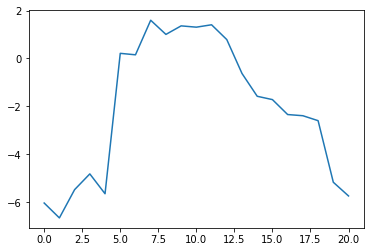

In [80]:
#%pylab inline
plot(V)

In [21]:
script_dir = os.environ['REPO_DIR']
! python $script_dir/Shape_shift.py 'MD594' 112 'shape_params.yaml'

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/sklearn/externals/joblib/externals/cloudpickle/cloudpickle.py:47: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
/Users/kuiqian/Github/shapeology_code/scripts/lib/utils.py:22: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  self.D=yaml.load(open(yamlFile,'r'))
run cmd= aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_prep2_lossless_gray/MD594-IHC20-2015.08.26-16.26.10_MD594_1_0058_prep2_lossless_gray.tif /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD594/MD594_prep2_lossless_gray/MD594-IHC20-2015.08.26-16.26.10_MD594_1_0058_prep2_lossless_gray.tif
download: s3://mousebrainatlas-data/CSHL_data_processed

download: s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_prep2_lossless_gray/MD594-IHC21-2015.08.26-16.29.30_MD594_1_0061_prep2_lossless_gray.tif to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD594/MD594_prep2_lossless_gray/MD594-IHC21-2015.08.26-16.29.30_MD594_1_0061_prep2_lossless_gray.tif
run cmd= aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_prep2_lossless_gray/MD594-IHC21-2015.08.26-16.29.30_MD594_2_0062_prep2_lossless_gray.tif /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD594/MD594_prep2_lossless_gray/MD594-IHC21-2015.08.26-16.29.30_MD594_2_0062_prep2_lossless_gray.tif
download: s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_prep2_lossless_gray/MD594-IHC21-2015.08.26-16.29.30_MD594_2_0062_prep2_lossless_gray.tif to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD594/MD594_prep2_lossless_gray/MD594-IHC21-2015.08.26-16.29.30_MD594_2_0062_prep2_lossless_gray.tif
run cmd= aws s3 cp s3:

In [269]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['contour', 'f', 'time', 'Polygon', 'test', 'info', 'stack']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [267]:
contours_struc = contours.groupby('name')

In [276]:
setup_download_from_s3(savepath)

run cmd= aws s3 cp --recursive s3://mousebrainatlas-data/CSHL_shift_new/MD594/ /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_shift_new/MD594/


In [273]:
seq = sort(contours_struc.get_group('VCA')['section'].unique())
seq[:np.argmax(seq[2:]-seq[:-2])+2]

array([94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107,
       108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120,
       121, 122, 123, 124], dtype=object)

In [81]:
current_structures = []
for structure in paired_structures:
    seq = sort(contours_struc.get_group(structure)['section'].unique())
    if seq[np.argmax(seq[2:]-seq[:-2])+1]<150:
        current_structures.append(structure)
for structure in singular_structures:
    seq = sort(contours_struc.get_group(structure)['section'].unique())
    if max(seq)<146:
        current_structures.append(structure)

In [82]:
current_structures

['PBG', 'VCA', 'VCP']

ValueError: num must be 1 <= num <= 6, not 7

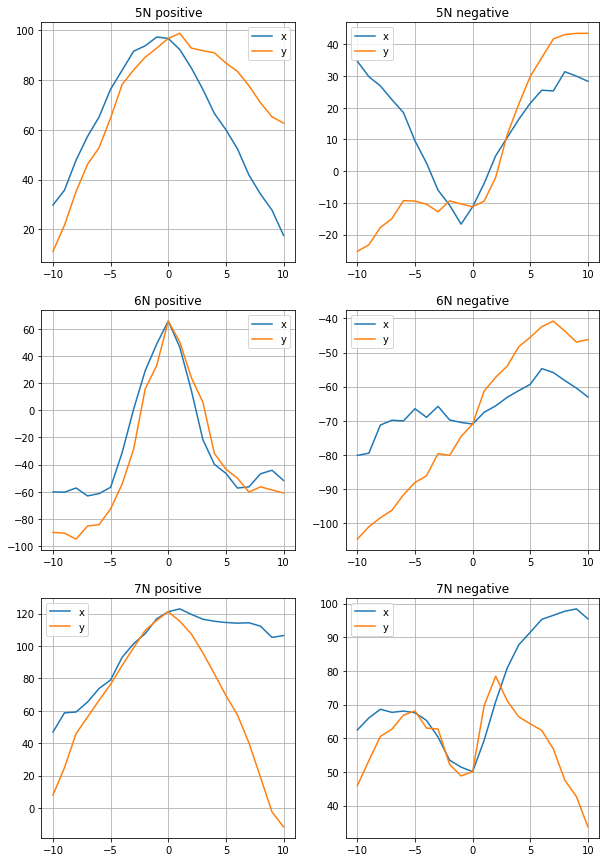

In [281]:
i = 0
figure(figsize=(10,15))
for structure in all_structures:
    seq = sort(contours_struc.get_group(structure)['section'].unique())
    sections = seq[:np.argmax(seq[2:]-seq[:-2])+2]
    for state in ['positive','negative']:
        x_shift = []
        y_shift = []
        for section in sections:
            filename = savepath + str(section)+ '.pkl'
            #setup_download_from_s3(filename, recursive=False)
            scores = pickle.load(open(os.environ['ROOT_DIR']+filename,'rb'))
            x_score=[x[0] for x in scores[structure][str(section)+'_'+state]['x']]
            x_shift.append(x_score)
            y_score=[x[0] for x in scores[structure][str(section)+'_'+state]['y']]
            y_shift.append(y_score)
        x_shift=np.array(x_shift)
        x_final = x_shift.sum(axis=0)
        y_shift=np.array(y_shift)
        y_final = y_shift.sum(axis=0)
        #figure()
        i +=1
        subplot(3,2,i)
        plot(range(-10,11), x_final, label='x')
        plot(range(-10,11), y_final, label='y')
        legend()
        grid(True)
        title(structure+' '+state)

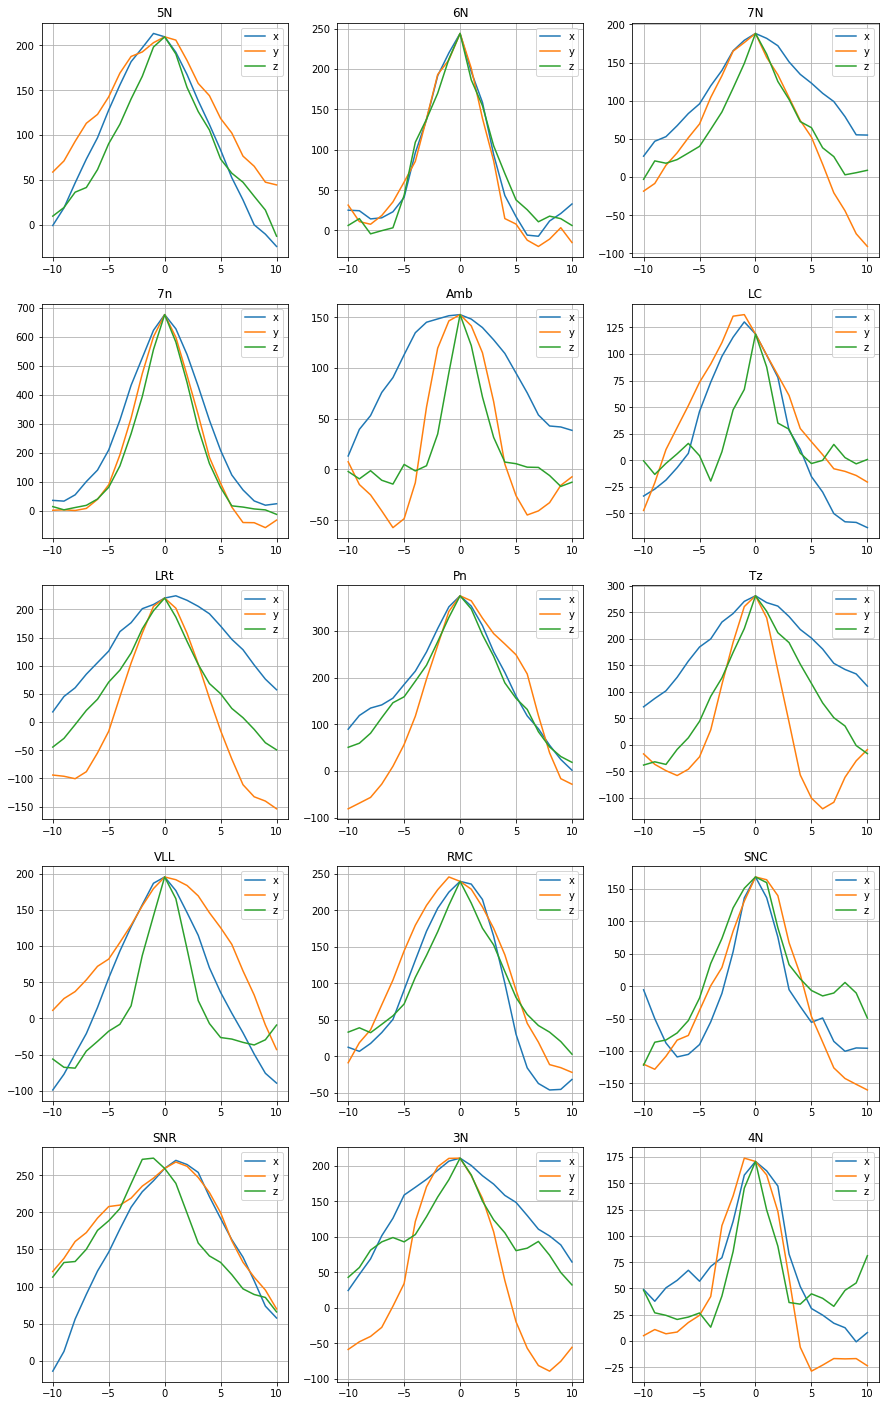

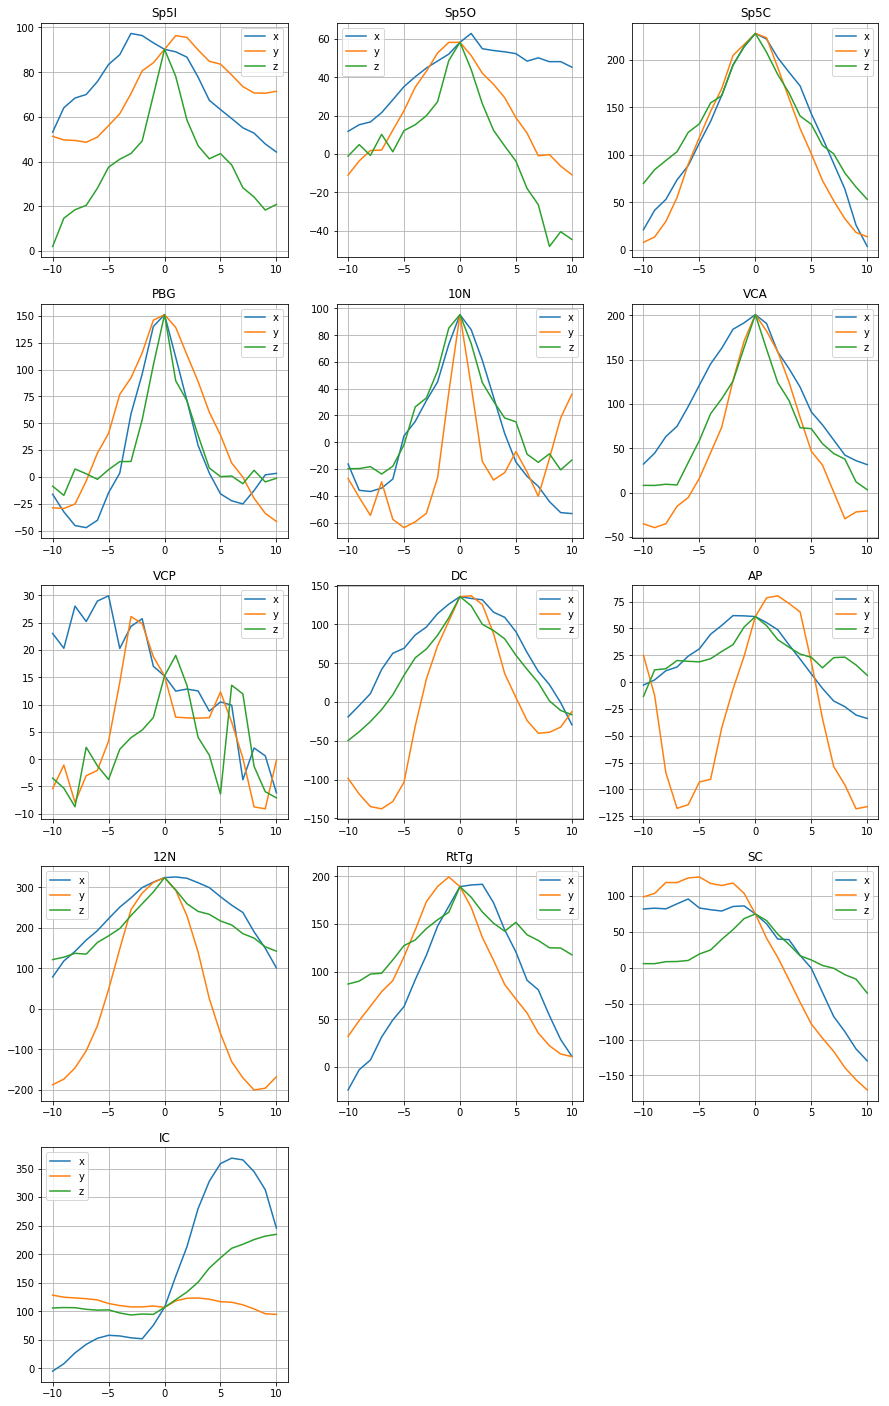

In [305]:
i = 0
figure(figsize=(15,25))
for structure in all_structures:
    seq = sort(contours_struc.get_group(structure)['section'].unique())
    x_shift = []
    y_shift = []
    z_shift = []
    for state in ['positive','negative']:
        for section in seq:
            filename = savepath + str(section)+ '.pkl'
            scores = pickle.load(open(os.environ['ROOT_DIR']+filename,'rb'))
            x_score= scores[structure][str(section)+'_'+state]['x']
            x_shift.append(x_score)
            y_score= scores[structure][str(section)+'_'+state]['y']
            y_shift.append(y_score)
            z_score= scores[structure][str(section)+'_'+state]['z']
            z_shift.append(z_score)
    x_shift=np.array(x_shift)
    y_shift=np.array(y_shift)
    z_shift=np.array(z_shift)
    num = len(seq)
    x_final = x_shift[:num,:].sum(axis=0) - x_shift[num:,:].sum(axis=0)
    y_final = y_shift[:num,:].sum(axis=0) - y_shift[num:,:].sum(axis=0)
    z_final = z_shift[:num,:].sum(axis=0) - z_shift[num:,:].sum(axis=0)
    i +=1
    if i==16:
        i=1
        savefig('Shift1.jpg')
        figure(figsize=(15,25))
    subplot(5,3,i)
    plot(range(-10,11), x_final, label='x')
    plot(range(-10,11), y_final, label='y')
    plot(range(-10,11), z_final, label='z')
    legend()
    grid(True)
    title(structure)
savefig('Shift2.jpg')

In [286]:
[x[0] for x in scores[structure][str(section)+'_'+state]['z']]

TypeError: 'int' object is not subscriptable

In [296]:
np.array(scores[structure][str(section)+'_'+state]['z']).sum(axis=0)

array([18.185797], dtype=float32)

In [299]:
np.array(x_shift).shape

(2, 21)